In [1]:
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from time import time
import logging

import pandas as pd

import numpy as np
import sklearn as sk
import seaborn as sns

import nltk
from nltk import word_tokenize
lang ='french'

import clean_text
import skmultilearn




import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,f1_score,classification_report
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD,IncrementalPCA,SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

import spacy
nlp =spacy.load('fr')
from spacy.lang.fr.stop_words import STOP_WORDS

In [2]:
%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')
df_effets = pd.read_csv("data/ref_MRV/referentiel_dispositif_effets_connus.csv",delimiter=';',encoding='ISO-8859-1')
df_dys = pd.read_csv("data/ref_MRV/referentiel_dispositif_dysfonctionnement.csv",delimiter=';',encoding='ISO-8859-1')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


In [3]:
from sentence_transformers import SentenceTransformer, models
word_embedding_model =  models.Transformer('./Models/Models/speed_camembert_max_len_128_fp16_dynamic_padding_smart_batching_batch_32_seed_321/')

pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=True,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class CamenBertVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X,y=None):
        return self

    def transform(self, X):
        if type(X)==str:       
            return np.array(self.model.encode([X],show_progress_bar=True, batch_size=10))
        elif type(X)==list :     
            return np.array(self.model.encode(X,show_progress_bar=True, batch_size=10))
        elif type(X)==pd.Series :      
            return np.array(self.model.encode(X.values.tolist(),show_progress_bar=True, batch_size=10))
        else :
            print('Please enter a list of string or a pandas Series')

In [65]:
%%time
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

def preprocess_pipeline(model =model, n =200) :
    return Pipeline([
        ('vect', CamenBertVectorTransformer(model = model)),
        ('svd', TruncatedSVD(n_components=n))
    ])

preprocess = ColumnTransformer(
    [('etat_pat_bert', preprocess_pipeline(model, 100) , 'ETAT_PATIENT'),
         
     ('description_bert',preprocess_pipeline(model, 100), 'DESCRIPTION_INCIDENT'),
     #('description_bert_svd',TruncatedSVD(n_components =200), 'description_bert')
     
     ('action_pat_bert',preprocess_pipeline(model, 50), 'ACTION_PATIENT'),
     
     ('fabricant_bert',preprocess_pipeline(model, 50), 'FABRICANT'),
          
    ],
    #
    remainder='passthrough')

preprocess_pipeline = Pipeline([
    ('vect', CamenBertVectorTransformer(model = model)),
    ('svd', TruncatedSVD(n_components =200))
    ])

X = df_declaration_mrv[:100][['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT','ACTION_PATIENT']].fillna('') 
X_prep = preprocess.fit_transform(X)

Batches: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

CPU times: user 6min 13s, sys: 27.4 s, total: 6min 40s
Wall time: 29.9 s


In [70]:
import joblib
le_effet = joblib.load('Models/Encoder_effets.sav')

In [67]:
np.save('/result/test.npy',X_prep)

FileNotFoundError: [Errno 2] No such file or directory: '/result/test.npy'

In [68]:
file_train = np.load('dgs_camembert_train.npz')
X_train = file_train['arr_0']
file_test =np.load('dgs_camembert_test.npz')
X_test = file_test['arr_0']
y_train = np.load('y_train_mlb.npy')
y_test = np.load('y_test_mlb.npy')

array([73, 73, 73, ..., 73, 73, 73])

In [74]:
df_train = pd.DataFrame(X_train)
df_train['label'] = np.argmax(y_train, axis=1)

df_test = pd.DataFrame(X_test)
df_test['label'] = np.argmax(y_test, axis=1)

In [78]:
cat_vect = df_train.groupby('label').mean()

In [88]:
len(cat_vect)

165

In [89]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

def predict(x,cat_vect) :
    max_sim = 0
    winner = -1
    for j in cat_vect.index :
        sim = cosine_similarity(x,cat_vect.loc[j].values.reshape(1, -1))
        if sim > max_sim :
            max_sim = sim
            winner = j
    return winner

P= []
for x in X_test : 
    P.append(predict(x.reshape(1, -1),cat_vect))

df_test['pred'] = P

CPU times: user 36min 5s, sys: 1.35 s, total: 36min 6s
Wall time: 36min 6s


In [90]:
print(f1_score(df_test['label'].values.tolist(),P,average='weighted'))

0.01285589984193289


In [85]:
cat_vect.loc[0].values.shape

(1536,)

In [84]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(cat_vect.loc[0].values.reshape(1, -1),cat_vect.loc[4].values.reshape(1, -1))

array([[0.9818108]], dtype=float32)

In [39]:
text = df_declaration_mrv['DESCRIPTION_INCIDENT'][0]
enc = CamenBertVectorTransformer(model = model)
X = enc.transform(text)

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


In [36]:
X.shape

(2, 1536)

In [17]:
print([sentences for sentences in df_declaration_mrv['DESCRIPTION_INCIDENT'][0]])

['L', 'e', ' ', 'g', 'u', 'i', 'd', 'e', ' ', 'e', 's', 't', ' ', 'r', 'e', 's', 't', 'é', ' ', 'c', 'o', 'i', 'n', 'c', 'é', ' ', 'à', ' ', 'l', "'", 'i', 'n', 't', 'é', 'r', 'i', 'e', 'u', 'r', ' ', 'd', 'e', ' ', 'l', 'a', ' ', 's', 'o', 'n', 'd', 'e', ',', ' ', 'o', 'n', ' ', 'n', 'e', ' ', 'p', 'e', 'u', 't', ' ', 'p', 'l', 'u', 's', ' ', 'l', 'e', ' ', 'b', 'o', 'u', 'g', 'e', 'r', '.', '\r', '\r', '\n', '\r', '\r', '\n', 'C', 'h', 'a', 'n', 'g', 'e', 'm', 'e', 'n', 't', ' ', 'd', 'e', ' ', 's', 'o', 'n', 'd', 'e']


In [16]:
X.shape

(104, 1, 1536)

In [9]:
df_declaration_mrv[:10][['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT','ACTION_PATIENT']].fillna('')

,DESCRIPTION_INCIDENT,ETAT_PATIENT,FABRICANT,ACTION_PATIENT
0,Le guide est resté coincé à l'intérieur de la ...,Changement de sonde,MEDTRONIC Inc,Matériel disponible au sce économat
1,Apparition de nombreux boutons,,BSN MEDICAL,
2,"Le sphinctérotome, à la sortie de son emballag...",..,BOSTON SCIENTIFIC,
3,Mandrin bloqué dans la sonde et impossibilité ...,..,Abbott Medical France SAS,Matériel à dispo au SCE économat.
4,Mandrin bloqué dans la sonde et impossibilité ...,..,Abbott Medical France SAS,Matériel à dispo au SCE économat.
5,La pince Kocher présente dans la trousse a été...,"Perte sanguine du bébé, la pince ne réalisant ...",VYGON,Un clamp ombilical a été mis en urgence.
6,Lors de l'ouverture d'un pack CATARACTE (Perso...,Pas de conséquences car non utilisation du DM.,Bausch & Lomb France,Changements de couteaux.
7,Lors de l'ouverture d'un pack CATARACTE (Perso...,Pas de conséquences car non utilisation du DM.,Bausch & Lomb France,Changements de couteaux.
8,Lors de l'ouverture d'un pack CATARACTE (Perso...,Pas de conséquences car non utilisation du DM.,Bausch & Lomb France,Changements de couteaux.
9,LA TUBULURE EST PINCEE JUSTE APRES LE SUPPORT ...,..,NUTRICIA NUTRITION CLINIQUE SAS,CHANGEMENT DE DM.


In [175]:
%%time
#On complète les effets vide comme étant sans effets
df_declaration_mrv['TYPE_EFFET']  = df_declaration_mrv['TYPE_EFFET'].fillna("PAS D'EFFET NEFASTE DECLARE")
df_declaration_mrv['TEF_ID']= df_declaration_mrv['TEF_ID'].fillna('E1213')



CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 11.8 ms


In [83]:
INCONNU_dys = ['NON LISTE','NON FONCTIONNEMENT / FONCTIONNEMENT INCORRECT', 'NON RENSEIGNE', 'DISPOSITIF DEFECTUEUX',
           'DYSFONCTIONNEMENT']
nan = df_declaration_mrv['CONSEQUENCE_DYSFONCTIONNEMENT'][0]

def fill_na_dys(x):
    if x == 0:
        return(0)
    elif x in INCONNU_dys:
        return(0)
    else :
        return(1)

def fill_na_effet(x):
    if x =="PAS D'EFFET NEFASTE DECLARE":
        return 0
    else :
        return 1
def fill_na_csq(x):
    if x==0:
        return(0)
    else :
        return(1)
    
def fill_type(x):
    if x=='Matériovigilance' :
        return 0
    else :
        return 1
    

df_declaration_mrv['EFFETS'] = df_declaration_mrv['TYPE_EFFET'].fillna("PAS D'EFFET NEFASTE DECLARE").apply(fill_na_effet)
df_declaration_mrv['DYS'] = df_declaration_mrv['TYPE_DYSFONCTIONNEMENT'].fillna(0).apply(fill_na_dys)
df_declaration_mrv['CSQ'] = df_declaration_mrv['CONSEQUENCE_DYSFONCTIONNEMENT'].fillna(0).apply(fill_na_csq)
df_declaration_mrv['VIGI'] = df_declaration_mrv['TYPE_VIGILANCE'].apply(fill_type)

df = df_declaration_mrv[['CSQ','EFFETS','DYS','VIGI']]

#print(len(df_declaration_mrv[df_declaration_mrv['CONSEQUENCE_DYSFONCTIONNEMENT'].isna()]))

In [82]:
df_declaration_mrv['TYPE_VIGILANCE'].unique()

array(['Matériovigilance', 'Réactovigilance'], dtype=object)

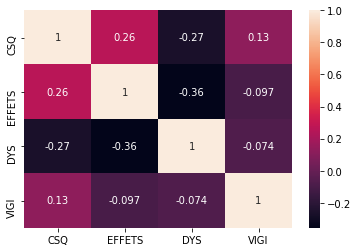

In [84]:
corr = df.corr()
sns.heatmap(corr,annot=True)

In [90]:
len(df[df['VIGI']==1][df['CSQ']==1])

1035

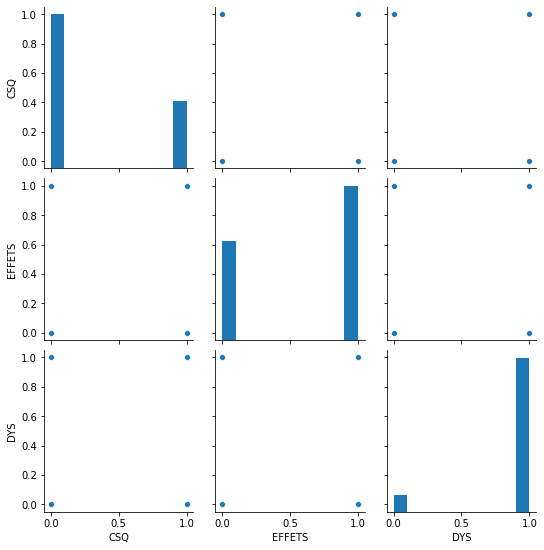

In [63]:
import seaborn as sns

sns.pairplot(df)

In [25]:
print(len(df_declaration_mrv[df_declaration_mrv['CONSEQUENCE_DYSFONCTIONNEMENT'].isna()][df_declaration_mrv['TEF_ID']=='E1213']))

25439


In [176]:
d = df_declaration_mrv.groupby(['TYPE_EFFET'])['DCO_ID'].count().sort_values(ascending=False).reset_index(name='count')

In [189]:
d[d['TYPE_EFFET'].map(lambda x:str(x).find('FRACT'))!=-1]

,TYPE_EFFET,count
130,PIQURE / EFFRACTION CUTANEE,31
149,REFRACTION RESIDUELLE / ERREUR REFRAC POST OP,22
170,FRACTURE PERI - PROTHETIQUE,16
208,FRACTURE OSSEUSE,6


In [179]:
d['TYPE_EFFET'].iloc[126]

'EXPLANTATION CHIRURGICALE DU DM'

In [180]:
d['TYPE_EFFET'].iloc[137]

'EXPLANTATION  CHIRURGICALE DU DM'

In [142]:
d['TYPE_DYSFONCTIONNEMENT'][5]

'IMPOSSIBILITE / DIFFICULTE DE POSE / MISE EN PLACE'

In [143]:
df_l = df_declaration_mrv.groupby(['DESCRIPTION_INCIDENT'])['CONSEQUENCE_DYSFONCTIONNEMENT'].apply(list).reset_index(name='multilabel')


In [125]:
len(df_declaration_mrv.drop_duplicates('ETAT_PATIENT',keep='first')[df_declaration_mrv['CSQ']==1])/len(df_declaration_mrv.drop_duplicates('ETAT_PATIENT',keep='first'))

0.24305620065025546

In [126]:
len(df_declaration_mrv.drop_duplicates('ETAT_PATIENT',keep='first')[df_declaration_mrv['CSQ']==1])

5233

In [151]:
dico = {}
for elt in d['TYPE_EFFET'].values :
    dico[elt] = [elt]

In [152]:
dico

{"PAS D'EFFET NEFASTE DECLARE": ["PAS D'EFFET NEFASTE DECLARE"],
 'SYMPTOMES MULTIPLES': ['SYMPTOMES MULTIPLES'],
 'CHIRURGIE DE REVISION': ['CHIRURGIE DE REVISION'],
 'RETARD AU TRAITEMENT': ['RETARD AU TRAITEMENT'],
 'DOULEUR NON GYNECO': ['DOULEUR NON GYNECO'],
 'FATIGUE': ['FATIGUE'],
 'DOULEUR PELVIENNE OU  ABDOMINALE': ['DOULEUR PELVIENNE OU  ABDOMINALE'],
 'RETRAIT CHIRURGICAL': ['RETRAIT CHIRURGICAL'],
 'SAIGNEMENT / HEMATOME': ['SAIGNEMENT / HEMATOME'],
 'AUTRE': ['AUTRE'],
 'DOULEUR': ['DOULEUR'],
 'SF NEURO': ['SF NEURO'],
 'SF ORL': ['SF ORL'],
 'REINTERVENTION NON CHIRURGICALE': ['REINTERVENTION NON CHIRURGICALE'],
 'REACTION ALLERGIQUE': ['REACTION ALLERGIQUE'],
 'SF DIGESTIF': ['SF DIGESTIF'],
 'SF OPHTALMO': ['SF OPHTALMO'],
 'PERTE DE SANG': ['PERTE DE SANG'],
 'INFLAMMATION': ['INFLAMMATION'],
 'BRULURE': ['BRULURE'],
 'DECES': ['DECES'],
 ' ( PARTIE DE) DM NON RETIRE / NON EXPLANTE': [' ( PARTIE DE) DM NON RETIRE / NON EXPLANTE'],
 'DEPRESSION': ['DEPRESSION'],
 'SF 

In [278]:
len(dico1)

237

In [274]:
dico1 =  {
    "PAS D'EFFET NEFASTE DECLARE": ["PAS D'EFFET NEFASTE DECLARE",'AUCUN EFFET CLINIQUE DECLARE'],
    "VAGUES" : ["SYMPTOMES MULTIPLES","AUTRE","AUTRES HORS PELVIEN"],
    "CHIRURGIE DE REVISION" :['CHIRURGIE DE REVISION','CHIRURGIE DE REVISION NON LIEE A DEFAILLANCE DM','CHIRURGIE DE REVISION NON LIEE A DEFAILLANCE DM'],
    "RETARD AU TRAITEMENT" : ["RETARD AU TRAITEMENT"],
    "FATIGUE" : ['FATIGUE'],
    "SAIGNEMENT / HEMATOME" : ["SAIGNEMENT / HEMATOME",'PERTE DE SANG'],
    "DOULEUR_NON_GYNECO" : ["DOULEUR NON GYNECO"],
    "RETRAIT CHIRURGICAL":['RETRAIT CHIRURGICAL'],
    "DOULEUR PELVIENNE OU  ABDOMINALE": ["DOULEUR PELVIENNE OU  ABDOMINALE"],
    "DOULEUR" :['DOULEUR','DOULEURS, GÊNE FONCTIONNELLE'],
    "SF NEURO" :["SF NEURO"],
    "SF ORL":["SF ORL"],
    'REINTERVENTION NON CHIRURGICALE': ['REINTERVENTION NON CHIRURGICALE'],
    'REACTION ALLERGIQUE': ['REACTION ALLERGIQUE','ALLERGIE','ALLERGIE CONFIRMEE','UTILISATEUR : ALLERGIE',
                           'REACTION ALLERGIQUE LOCALISEE'],
    'SF DIGESTIF': ['SF DIGESTIF'],
    'SF OPHTALMO': ['SF OPHTALMO'],
    'BRULURE': ['BRULURE','BLESSURE UTILISATEUR : BRULURE'],
    'DECES': ['DECES'],
    ' ( PARTIE DE) DM NON RETIRE / NON EXPLANTE': [' ( PARTIE DE) DM NON RETIRE / NON EXPLANTE'],
    'DEPRESSION': ['DEPRESSION'],
    'SF DERMATO': ['SF DERMATO'],
    'INFLAMMATION / INFECTION': ['INFECTION','INFECTION BACTERIENNE','INFLAMMATION / INFECTION','INFLAMMATION'],
    'HYPERGLYCEMIE': ['HYPERGLYCEMIE', 'HYPERGLYCEMIE SEVERE','HYPERGLYCEMIE SEVERE'],
    'TRAITEMENT INADAPTE': ['TRAITEMENT INADAPTE'],
    'NON RENSEIGNE' : [ 'NON RENSEIGNE'],
    'SF CARDIO': ['SF CARDIO'],
    'NON LISTE' :['NON LISTE'],
    'COQUE 3': ['COQUE 3'],
    'EXPLANTATION CONTROLATERALE PMI ROMPUE / PERSP': ['EXPLANTATION CONTROLATERALE PMI ROMPUE / PERSP'],
    'SF PULMONAIRE': ['SF PULMONAIRE'],
    "AES / RISQUE D'AES": ["AES / RISQUE D'AES",'AES','UTILISATEUR / AES'],
    'RETARD AU DIAGNOSTIC': ['RETARD AU DIAGNOSTIC'],
    'RÉIMPLANTATION CHIRURGICALE À RÉALISER': ['RÉIMPLANTATION CHIRURGICALE À RÉALISER'],
    'HEMORRAGIE': ['HEMORRAGIE'],
    'SC ORL': ['SC ORL'],
    'CHUTE': ['CHUTE'],
    'EPANCHEMENT': ['EPANCHEMENT'],
    'COQUE 4': ['COQUE 4'],
    'MYCOSE / CYSTITE /INFECTION URINAIRE': ['MYCOSE / CYSTITE /INFECTION URINAIRE'],
    'EFFET INDESIRABLE': ['EFFET INDESIRABLE'],
    'SC ENDOCRINO': ['SC ENDOCRINO'],
    'EXPLANTATION SS SIGNE CLINIQUE OU RADIO': ['EXPLANTATION SS SIGNE CLINIQUE OU RADIO'],
    'COQUE 1 OU 2': ['COQUE 1 OU 2'],
    'DESATURATION EN OXYGENE': ['DESATURATION EN OXYGENE'],
    'SF URINAIRE': ['SF URINAIRE'],
    'PRURIT': ['PRURIT'],
    'ENDOMETRIOSE / ADENOMYOSE': ['ENDOMETRIOSE / ADENOMYOSE'],
    "RISQUE POUR L'UTILISATEUR": ["RISQUE POUR L'UTILISATEUR"],
    'COQUE': ['COQUE'],
    'CONVERSION EN CHIRURGIE OUVERTE': ['CONVERSION EN CHIRURGIE OUVERTE'],
    'GROSSESSE': ['GROSSESSE'],
    'OEDEME': ['OEDEME'],
    'MALAISE': ['MALAISE'],
    'BLESSURE': ['BLESSURE'],
    'PERFORATION DE PAROI': ['PERFORATION DE PAROI'],
    'ERYTHEME': ['ERYTHEME'],
    'EMBOLIE GAZEUSE': ['EMBOLIE GAZEUSE'],
    'DIVERSE COMPLICATION': ['DIVERSE COMPLICATION'],
    'SILICONOME': ['SILICONOME'],
    'HYPOGLYCEMIE': ['HYPOGLYCEMIE','HYPOGLYCEMIE SEVERE'],
    'ARRET CARDIO-RESPIRATOIRE ( ACR )': ['ARRET CARDIO-RESPIRATOIRE ( ACR )'],
    'LUXATION / SUBLUXATION': ['LUXATION / SUBLUXATION'],
    'ADENOPATHIE': ['ADENOPATHIE'],
    'ARRACHEMENT DE TISSU': ['ARRACHEMENT DE TISSU'],
    'FIBROME UTERIN ( OU POLYPE ) ': ['FIBROME UTERIN ( OU POLYPE ) '],
    'CHOC INAPPROPRIE': ['CHOC INAPPROPRIE'],
    'ECHEC THERAPEUTIQUE': ['ECHEC THERAPEUTIQUE'],
    'INCIDENT PER OPERATOIRE': ['INCIDENT PER OPERATOIRE'],
    'TROUBLE DU RYTHME CARDIAQUE': ['TROUBLE DU RYTHME CARDIAQUE'],
    'HYPERGLYCEMIE CETOSE': ['HYPERGLYCEMIE CETOSE','CETOSE'],
    'TEMPS CHIRURGICAL ALLONGE': ['TEMPS CHIRURGICAL ALLONGE'],
    'BLESSURE': ['BLESSURE','BLESSURE LEGERE OCCASIONNEE PAR UN DM','BLESSURE LEGERE',"BLESSURE DE L'OPERATEUR",
                 'BLESSURE UTILISATEUR : LEGERE','UTILISATEUR : BLESSURE'],
    'BLESSURE GRAVE' :['BLESSURE GRAVE','BLESSURE GRAVE OCCASIONNEE PAR UN DM','BLESSURE UTILISATEUR : GRAVE'],
    'LAGC': ['LAGC'],
    'LESION CUTANEE': ['LESION CUTANEE'],
    'LYMPHOREE': ['LYMPHOREE'],
    'CANCER': ['CANCER'],
    'PLAIE VASCULAIRE': ['PLAIE VASCULAIRE'],
    'DESCELLEMENT': ['DESCELLEMENT'],
    'DIAGNOSTIC ERRONE': ['DIAGNOSTIC ERRONE'],
    'EXPOSITION / EROSION': ['EXPOSITION','EXPOSITION/EROSION','EROSION','EXPOSITION / EROSION'],
    'SUREXPOSITION': ['SUREXPOSITION'],
    'GRANULOME': ['GRANULOME'],
    'MENACE DU PRONOSTIC VITAL': ['MENACE DU PRONOSTIC VITAL'],
    'EPANCHEMENT / HEMATOME': ['EPANCHEMENT / HEMATOME'],
    'THROMBOSE': ['THROMBOSE','THROMBOSE <30J','THROMBOSE >30J'],
    'SC NEURO': ['SC NEURO'],
    'METALLOSE': ['METALLOSE'],
    'ABCES': ['ABCES'],
    'KYSTE OVARIEN / NEOPLASME OVAIRE': ['KYSTE OVARIEN / NEOPLASME OVAIRE'],
    'CONTAMINATION': ['CONTAMINATION'],
    'PINCEMENT / PIEGEAGE': ['PIEGEAGE','PINCEMENT / PIEGEAGE'],
    'PROCEDURE CHIRURGICALE MODIFIEE': ['PROCEDURE CHIRURGICALE MODIFIEE'],
    'MALADIE AUTO - IMMUNE': ['MALADIE AUTO - IMMUNE'],
    'PROBLEME DE CICATRISATION': ['CICATRISATION DIFFICILE','RETARD CICATRISATION','PROBLEME DE CICATRISATION'],
    "PROLONGATION D'HOSPITALISATION": ["PROLONGATION D'HOSPITALISATION"],
    'COMA': ['COMA'],
    'CHOC CARDIOGENIQUE / HEMORRAGIQUE': ['CHOC CARDIOGENIQUE / HEMORRAGIQUE'],
    'SC DIGESTIF': ['SC DIGESTIF'],
    'PIQURE / EFFRACTION CUTANEE': ['PIQURE / EFFRACTION CUTANEE'],
    "REJET DE L'IMPLANT": ["REJET DE L'IMPLANT"],
    'EFFET INDESIRABLE AVEC UN IMPLANT': ['EFFET INDESIRABLE AVEC UN IMPLANT'],
    'ESCARRES': ['ESCARRES'],
    'CHIRURGIE ADDITIONNELLE': ['CHIRURGIE ADDITIONNELLE'],
    'EXPLANTATION CHIRURGICALE DU DM' :['EXPLANTATION  CHIRURGICALE DU DM','EXPLANTATION CHIRURGICALE DU DM'],
    'AVC - ACCIDENT VASCULAIRE CEREBRAL': ['AVC - ACCIDENT VASCULAIRE CEREBRAL'],
    'CONTAMINATION DM': ['CONTAMINATION DM'],
    'ABSENCE DE DIAGNOSTIC': ['ABSENCE DE DIAGNOSTIC'],
    'DEHISCENCE': ['DEHISCENCE'],
    'PERTE DE CONNAISSANCE': ['PERTE DE CONNAISSANCE'],
    "NON / MAUVAISE INTEGRATION D'UN IMPLANT": ["NON / MAUVAISE INTEGRATION D'UN IMPLANT"],
    'GROSSESSE EXTRA - UTERINE': ['GROSSESSE EXTRA - UTERINE'],
    "EMPLOI D'UN DM ALTERNATIF": ["EMPLOI D'UN DM ALTERNATIF"],
    'LUXATION INTRA-PROTHETIQUE': ['LUXATION INTRA-PROTHETIQUE'],
    'NODULE': ['NODULE'],
    'INDURATION': ['INDURATION'],
    'REFRACTION RESIDUELLE / ERREUR REFRAC POST OP': ['REFRACTION RESIDUELLE / ERREUR REFRAC POST OP'],
    "BAISSE D'ACUITE VISUELLE": ["BAISSE D'ACUITE VISUELLE"],
    'ANGOR / INFARCTUS': ['ANGOR / INFARCTUS'],
    'DEFAILLANCE MULTIVISCERALE': ['DEFAILLANCE MULTIVISCERALE'],
    'SECHERESSE': ['SECHERESSE'],
    'GENE RESPIRATOIRE': ['GENE RESPIRATOIRE'],
    "MIGRATION DE L'IMPLANT": ["MIGRATION DE L'IMPLANT"],
    'LÉSION OSSEUSE': ['LÉSION OSSEUSE'],
    'STOMIE TEMPORAIRE': ['STOMIE TEMPORAIRE'],
    'PERTE CELLULES ENDOTHELIALES': ['PERTE CELLULES ENDOTHELIALES'],
    'ENDOPHTALMIE': ['ENDOPHTALMIE'],
    'ANXIETE': ['ANXIETE'],
    'PERTE DE CHANCE PROCREATION': ['PERTE DE CHANCE PROCREATION'],
    'PERITONITE': ['PERITONITE'],
    'FRACTURE PERI - PROTHETIQUE': ['FRACTURE PERI - PROTHETIQUE'],
    'MASSE': ['MASSE'],
    'PSEUDOTUMEUR': ['PSEUDOTUMEUR'],
    'ELECTROCUTION': ['ELECTROCUTION'],
    'TROUBLE DU SOMMEIL': ['TROUBLE DU SOMMEIL'],
    'INSTABILITE': ['INSTABILITE','INSTABILITÉ'],
    'ULCERE': ['ULCERE'],
    'VISION TROUBLE': ['VISION TROUBLE'],
    'ALLERGIE, CYTOTOXICITE': ['ALLERGIE, CYTOTOXICITE'],
    'REACTION VIOLENTE': ['REACTION VIOLENTE'],
    'CONSEQUENCE IRREVERSIBLE': ['CONSEQUENCE IRREVERSIBLE'],
    'GONFLEMENT/ OEDEME': ['GONFLEMENT/ OEDEME'],
    'OSTEOLYSE': ['OSTEOLYSE'],
    'DESCELLEMENT, OSTEOLYSE': ['DESCELLEMENT, OSTEOLYSE'],
    'OCCLUSION INTESTINALE': ['OCCLUSION INTESTINALE'],
    'STENOSE / RESTENOSE': ['STENOSE / RESTENOSE'],
    'LYMPHOME': ['LYMPHOME'],
    'NAUSEE': ['NAUSEE'],
    'DOUBLE CAPSULE': ['DOUBLE CAPSULE'],
    'LESION ORGANE PELVIEN ( HORS PERFOR ET INF ) ': ['LESION ORGANE PELVIEN ( HORS PERFOR ET INF ) '],
    'ETRANGLEMENT': ['ETRANGLEMENT'],
    'HYPODRAINAGE': ['HYPODRAINAGE'],
    'RECANALISATION': ['RECANALISATION'],
    'DESEQUILIBRE / CHUTE': ['DESEQUILIBRE / CHUTE'],
    'EPANCHEMENT / TAMPONNADE / POP': ['EPANCHEMENT / TAMPONNADE / POP'],
    'LIO POST OP : VISION TROUBLE / HALOS': ['LIO POST OP : VISION TROUBLE / HALOS'],
    'INSUFFISANCE RENALE': ['INSUFFISANCE RENALE'],
    'REACTION A UN DISPOSITIF DENTAIRE': ['REACTION A UN DISPOSITIF DENTAIRE'],
    'INSUFFISANCE CARDIAQUE': ['INSUFFISANCE CARDIAQUE'],
    'POST OP : VISION TROUBLE / HALOS': ['POST OP : VISION TROUBLE / HALOS'],
    'KERATITE': ['KERATITE'],
    'OCCLUSION VASCULAIRE': ['OCCLUSION VASCULAIRE'],
    'HYPERTONIE / GLAUCOME': ['HYPERTONIE / GLAUCOME'],
    'CONDENSATION': ['CONDENSATION'],
    'PNEUMOPERITOINE': ['PNEUMOPERITOINE'],
    'FROTTEMENT / ERAFLURE': ['FROTTEMENT / ERAFLURE'],
    'EXTUBATION INVOLONTAIRE': ['EXTUBATION INVOLONTAIRE'],
    'FRACTURE OSSEUSE': ['FRACTURE OSSEUSE'],
    'ABSENCE DE PERTE DE POIDS': ['ABSENCE DE PERTE DE POIDS'],
    'CONVULSION': ['CONVULSION'],
    'CHOC ANAPHYLACTIQUE': ['CHOC ANAPHYLACTIQUE'],
    'AIT - ACCIDENT ISCHEMIQUE TRANSITOIRE': ['AIT - ACCIDENT ISCHEMIQUE TRANSITOIRE'],
    'OPACITE': ['OPACITE'],
    'RETRACTION / FIBROSE': ['RETRACTION / FIBROSE'],
    'ISCHEMIE': ['ISCHEMIE'],
    'EVENTRATION': ['EVENTRATION'],
    'SENSATION DE BRULURE': ['SENSATION DE BRULURE'],
    'PSEUDARTHROSE': ['PSEUDARTHROSE'],
    'ADHERENCES': ['ADHERENCES'],
    'FAUX ANEVRISME': ['FAUX ANEVRISME'],
    "RUPTURE D'ANEVRISME": ["RUPTURE D'ANEVRISME"],
    'AMPUTATION': ['AMPUTATION'],
    'THROMBOPENIE': ['THROMBOPENIE'],
    'VOMISSEMENTS': ['VOMISSEMENTS'],
    'PERTE DE VISION': ['PERTE DE VISION'],
    'GRADIENT DE PRESSION AUGMENTE': ['GRADIENT DE PRESSION AUGMENTE'],
    'FAUX POSITIF': ['FAUX POSITIF'],
    'DESASSEMBLAGE POST - OPERATOIRE': ['DESASSEMBLAGE POST - OPERATOIRE'],
    'HEMOLYSE': ['HEMOLYSE'],
    'HYPERDRAINAGE': ['HYPERDRAINAGE'],
    'EMBOLIE PULMONAIRE': ['EMBOLIE PULMONAIRE'],
    'ENDOSCOPIE': ['ENDOSCOPIE'],
    'PROLAPSUS': ['PROLAPSUS'],
    'PEAU ARRACHEE SOUS PLAQUE': ['PEAU ARRACHEE SOUS PLAQUE'],
    'FEMOROTOMIE': ['FEMOROTOMIE'],
    'GENE AUDITIVE': ['GENE AUDITIVE'],
    'MAL ETRE': ['MAL ETRE'],
    'PARESTHESIE': ['PARESTHESIE'],
    'PARALYSIE': ['PARALYSIE','PARALYSIE FACIALE'],
    'HYPERCAPNIE': ['HYPERCAPNIE'],
    'OTITE': ['OTITE'],
    'LACHAGE DE LA THERMOFUSION': ['LACHAGE DE LA THERMOFUSION'],
    'EFFETS RESPIRATOIRE INDESIRABLE': ['EFFETS RESPIRATOIRE INDESIRABLE'],
    'DECHARGE ELECTRIQUE': ['DECHARGE ELECTRIQUE'],
    'CONJONCTIVITE': ['CONJONCTIVITE'],
    'DIARRHÉE': ['DIARRHÉE'],
    'DELEUCOCYTATION HORS NORME': ['DELEUCOCYTATION HORS NORME'],
    'DEFAUT ECHANGE AIR / LIQUIDE': ['DEFAUT ECHANGE AIR / LIQUIDE'],
    'MICROCALCIFICATIONS BEGNIGNES': ['MICROCALCIFICATIONS BEGNIGNES'],
    'CARDIOPATHIE': ['CARDIOPATHIE'],
    'PHLEBITE': ['PHLEBITE'],
    'CHIRURGIE DE REVISION : CAUSE INCONNUE': ['CHIRURGIE DE REVISION : CAUSE INCONNUE'],
    'OSSIFICATION': ['OSSIFICATION'],
    'REJET DE CHAMBRE': ['REJET DE CHAMBRE','EXTERIORISATION / INTOLERANCE DE LA CHAMBRE'],
    'CONNECTIVITE': ['CONNECTIVITE'],
    'ALGONEURODYSTROPHIE': ['ALGONEURODYSTROPHIE'],
    'GEODE': ['GEODE'],
    'INTOLERANCE ALIMENTAIRE': ['INTOLERANCE ALIMENTAIRE'],
    'RUPTURE CAPSULAIRE': ['RUPTURE CAPSULAIRE'],
    'NEO - CAPSULE': ['NEO - CAPSULE'],
    "PRESOMPTION D'INTOXICATION AUX METAUX LOURDS": ["PRESOMPTION D'INTOXICATION AUX METAUX LOURDS"],
    'DM PERIME IMPLANTE': ['DM PERIME IMPLANTE'],
    "INFILTRATION DE LIQUIDE D'IRRIGATION": ["INFILTRATION DE LIQUIDE D'IRRIGATION"],
    'ACIDOCETOSE': ['ACIDOCETOSE'],
    'DOULEUR PER OP': ['DOULEUR PER OP'],
    'NECROSE': ['NECROSE'],
    'TAMPONNADE / PERFORATION / EPANCHEMENT PERICARDIQUE': ['TAMPONNADE / PERFORATION / EPANCHEMENT PERICARDIQUE'],
    'PERTE DE CHEVEUX': ['PERTE DE CHEVEUX'],
    'REACTION INDESIRABLE PDT / APRES PROCEDURE': ['REACTION INDESIRABLE PDT / APRES PROCEDURE'],
    'FISTULE POST OPERATOIRE': ['FISTULE POST OPERATOIRE'],
    'ELÉVATION IONS MÉTALLIQUES': ['ELÉVATION IONS MÉTALLIQUES'],
    'CEPHALEE': ['CEPHALEE'],
    'HYPOTHERMIE / HYPERTHERMIE': ['HYPOTHERMIE / HYPERTHERMIE'],
    'DISSECTION': ['DISSECTION'],
    "DIFFICULTE / IMPOSSIBILITE D'IMPLANTER":["DIFFICULTE / IMPOSSIBILITE D'IMPLANTER"],
    'TOXIC ANTERIOR SEGMENT SYNDROME': ['TOXIC ANTERIOR SEGMENT SYNDROME'],
    'AUGMENTATION DE VOLUME': ['AUGMENTATION DE VOLUME'],
    'PNEUMOTHORAX': ['PNEUMOTHORAX']
}





In [275]:
import json

with open('mapping_effet.json', 'w') as fp:
    json.dump(dico1, fp)

In [263]:
df= pd.read_json('mapping_effet.json',lines=True,orient='records')

In [264]:
df.to_csv('mapping_effet.csv')

In [246]:
d[d['TYPE_EFFET'].map(lambda x:str(x).find('DOULEUR'))!=-1]

,TYPE_EFFET,count
4,DOULEUR NON GYNECO,2168
6,DOULEUR PELVIENNE OU ABDOMINALE,1764
10,DOULEUR,1394
58,"DOULEURS, GÊNE FONCTIONNELLE",143
105,DOULEUR PER OP,49


In [215]:
d[d['TYPE_EFFET'].map(lambda x:str(x).find('VISION'))!=-1]

,TYPE_EFFET,count
2,CHIRURGIE DE REVISION,2751
178,VISION TROUBLE,13
196,LIO POST OP : VISION TROUBLE / HALOS,8
200,POST OP : VISION TROUBLE / HALOS,7
222,CHIRURGIE DE REVISION NON LIEE A DEFAILLANCE DM,5
229,PERTE DE VISION,4
259,CHIRURGIE DE REVISION : CAUSE INCONNUE,1


In [ ]:
'INCONNU' = ['NON LISTE','NON FONCTIONNEMENT / FONCTIONNEMENT INCORRECT', 'NON RENSEIGNE', 'DISPOSITIF DEFECTUEUX',
           'DYSFONCTIONNEMENT','AUTRE']